# [모의 캐글-의료] 흉부 CT 코로나 감염 여부 분류
- 이미지 binary 분류 과제
- 담당: 이녕민M

## Import Libraries

!sudo apt-get update && !sudo apt-get install -y python3-opencv

In [6]:

!pip install sklearn

You should consider upgrading via the '/home/smdf2545/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [7]:
import torch


torch.cuda.is_available()
torch.cuda.get_device_name(0)
torch.cuda.device_count()

torch.cuda.is_available() 
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2060'

In [17]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

## Set Arguments & hyperparameters

In [18]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [19]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= 'data'
NUM_CLS = 2

EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 10
INPUT_SHAPE = 128

os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

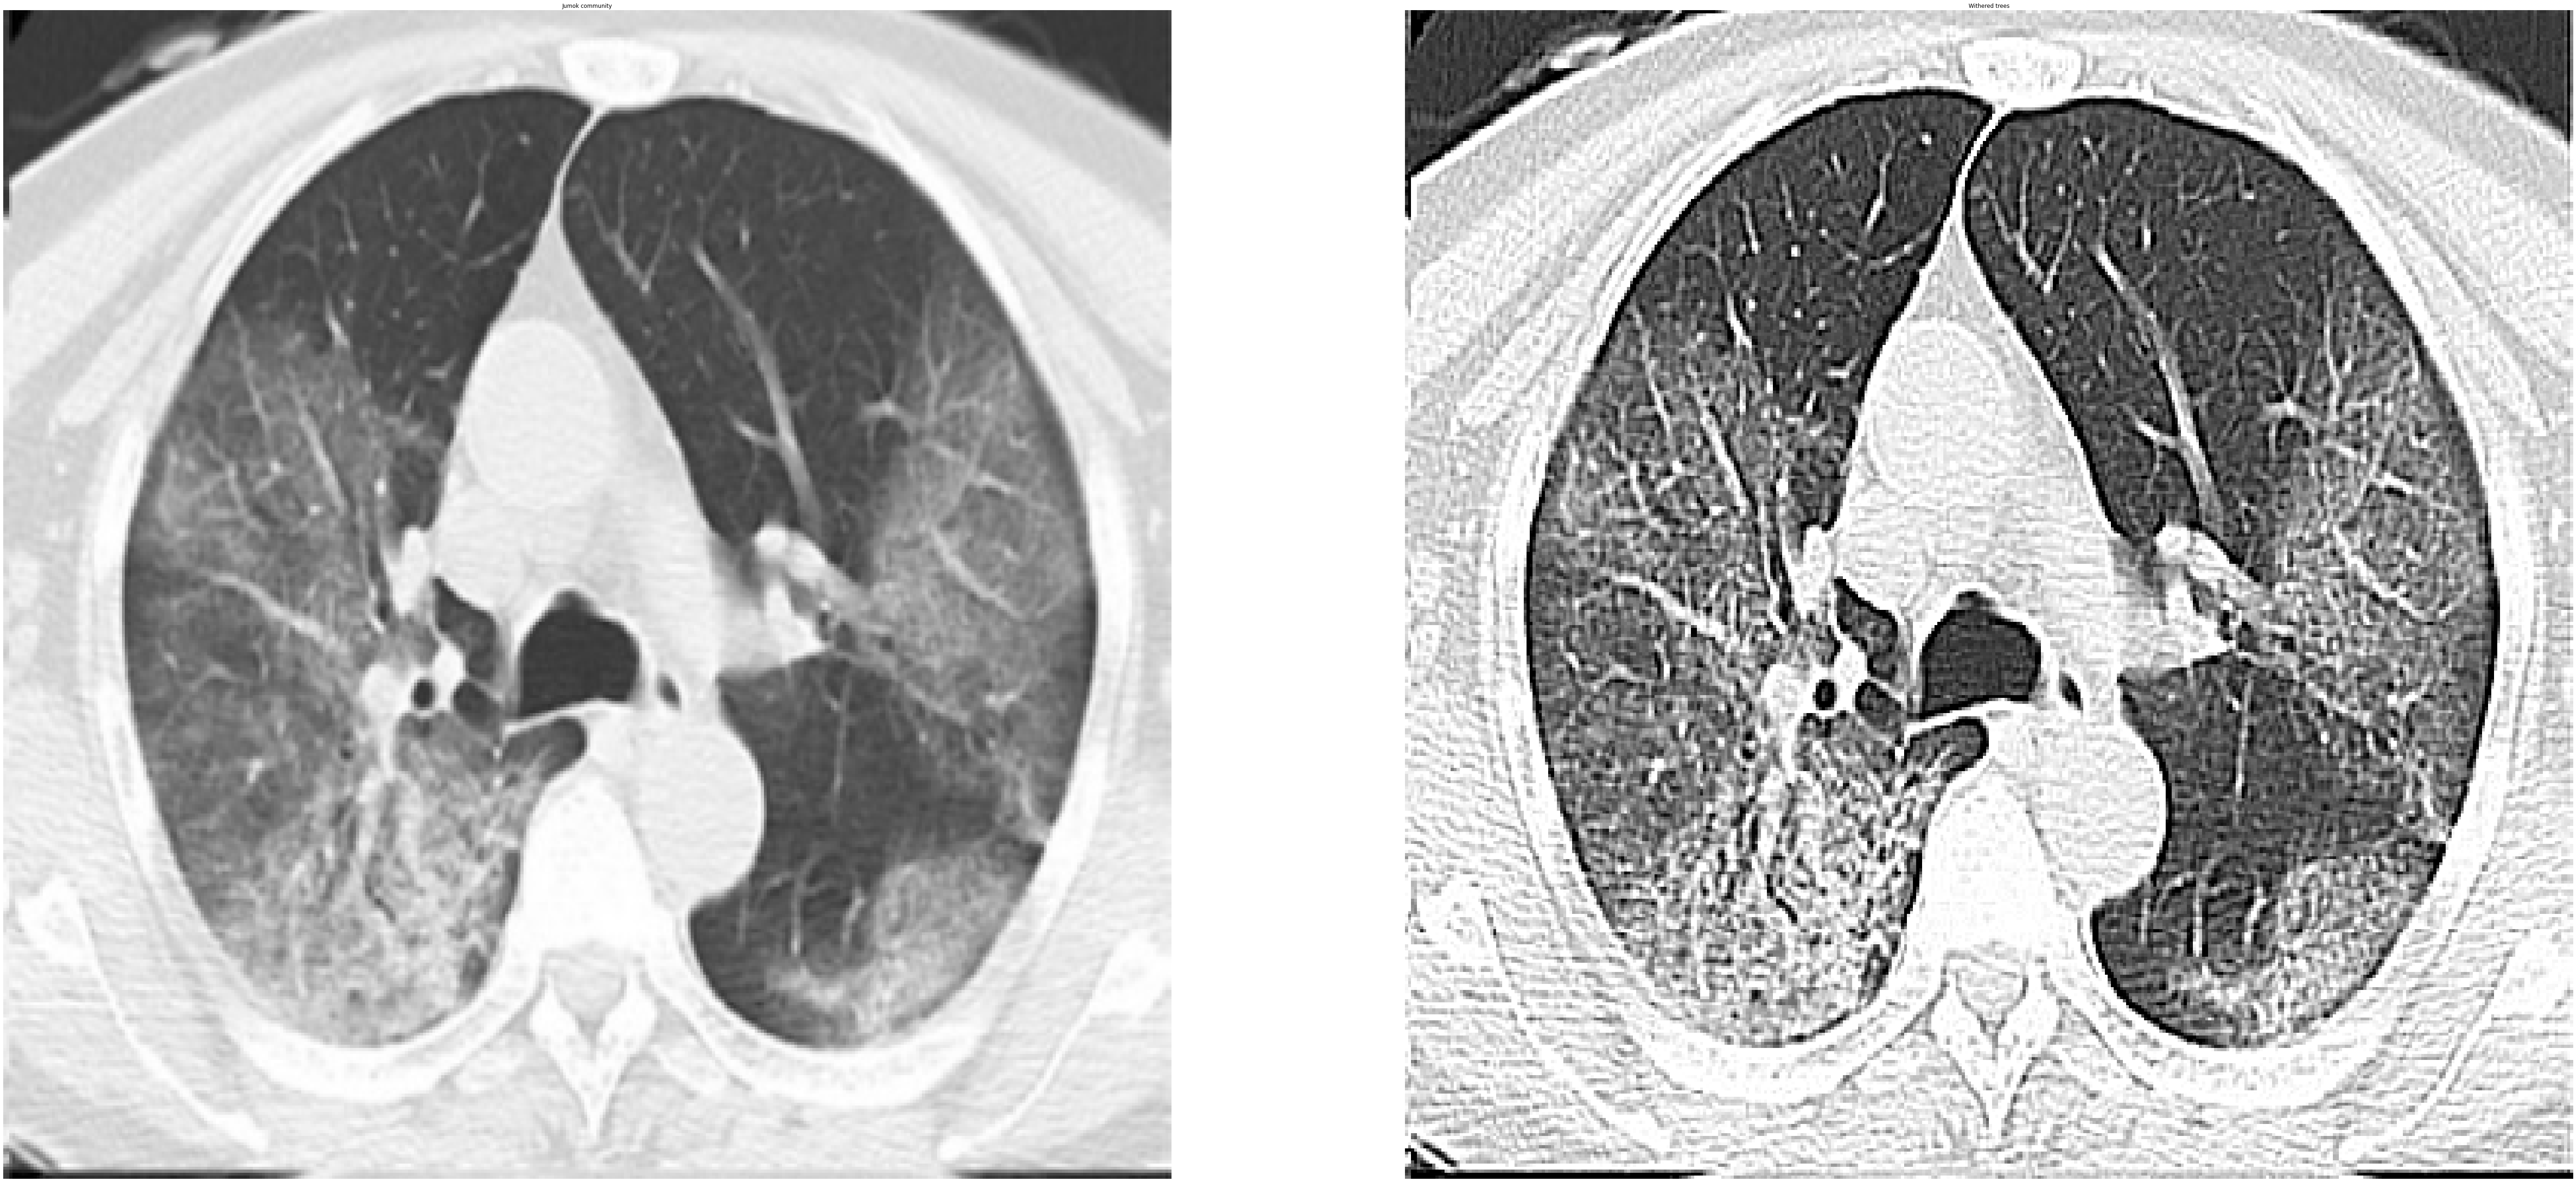

(384, 384, 3) (384, 384, 3)


In [16]:
import matplotlib.pyplot as plt
sharppening = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

cvimg = cv2.imread('/USER/data/train/31.png', cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
img = cv2.filter2D(cvimg, -1, sharppening)
fig = plt.figure(figsize=(100,100))
rows = 1
cols = 2
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB))
ax1.set_title('Jumok community')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title('Withered trees')
ax2.axis("off")
 
plt.show()

print(cvimg.shape, img.shape)

## Dataloader

#### Train & Validation Set loader

In [20]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):
        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['COVID']


## Model

In [21]:
import torch.nn.functional as F

class custom_CNN(nn.Module):
    def __init__(self, num_classes):
        super(custom_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=25, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=25*29*29, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # (32, 3, 128, 128) -> (32, 8, 62, 62)
        x = self.pool(F.relu(self.conv2(x))) # (32, 8, 62, 62) -> (32, 25, 29, 29)
        
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        output = self.softmax(x)
        
        return output

## Utils
### EarlyStopper

In [22]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

### Trainer

In [23]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

### Metrics

In [24]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load Dataset & Dataloader

In [25]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Loading train dataset..
Loading val dataset..
Train set samples: 581 Val set samples: 65


#### Load model and other utils

In [26]:
# Load Model
model = custom_CNN(NUM_CLS).to(DEVICE)

# # Save Initial Model
# torch.save(model.state_dict(), 'initial.pt')

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn


# Set trainer
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [ ]:
model

### epoch 단위 학습 진행

In [27]:
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best.pt')


  0% 0/30 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.7280382547113631, Acc: 0.5335628227194492, F1-Macro: 0.3545106077687814


  3% 1/30 [00:54<26:18, 54.42s/it]

Epoch 0, Val loss: 1.028156965970993, Acc: 0.5538461538461539, F1-Macro: 0.45219412961348443
Epoch 1, Train loss: 0.7042654355367025, Acc: 0.6006884681583476, F1-Macro: 0.5844062947067239
Epoch 1, Val loss: 0.8408717513084412, Acc: 0.7384615384615385, F1-Macro: 0.738213693437574
Validation loss decreased 1.028156965970993 -> 0.8408717513084412


  7% 2/30 [01:38<23:54, 51.22s/it]

Epoch 2, Train loss: 0.6568038562933604, Acc: 0.648881239242685, F1-Macro: 0.6487053634940959
Epoch 2, Val loss: 0.9352953732013702, Acc: 0.676923076923077, F1-Macro: 0.656084656084656
Early stopping counter 1/10


 10% 3/30 [02:22<22:06, 49.13s/it]

Epoch 3, Train loss: 0.5808385113875071, Acc: 0.7332185886402753, F1-Macro: 0.7308939323761
Epoch 3, Val loss: 0.709122970700264, Acc: 0.7846153846153846, F1-Macro: 0.7845643939393939
Validation loss decreased 0.8408717513084412 -> 0.709122970700264


 13% 4/30 [03:06<20:34, 47.47s/it]

Epoch 4, Train loss: 0.5157864623599582, Acc: 0.7814113597246127, F1-Macro: 0.7806602161085597
Epoch 4, Val loss: 0.4898797329515219, Acc: 0.7846153846153846, F1-Macro: 0.7804054054054055
Validation loss decreased 0.709122970700264 -> 0.4898797329515219


 17% 5/30 [03:49<19:17, 46.31s/it]

Epoch 5, Train loss: 0.45355890277359223, Acc: 0.7882960413080895, F1-Macro: 0.7869606045700488
Epoch 5, Val loss: 0.47431956976652145, Acc: 0.7846153846153846, F1-Macro: 0.7782651072124757
Validation loss decreased 0.4898797329515219 -> 0.47431956976652145


 20% 6/30 [05:12<22:54, 57.25s/it]

Epoch 6, Train loss: 0.41253167556391823, Acc: 0.8330464716006885, F1-Macro: 0.8322513625093388
Epoch 6, Val loss: 0.4087556079030037, Acc: 0.8615384615384616, F1-Macro: 0.8603485318691811
Validation loss decreased 0.47431956976652145 -> 0.4087556079030037


 23% 7/30 [07:48<33:20, 86.97s/it]

Epoch 7, Train loss: 0.3772876279221641, Acc: 0.8364888123924269, F1-Macro: 0.8357863482061305
Epoch 7, Val loss: 0.7101148217916489, Acc: 0.7692307692307693, F1-Macro: 0.7683535281539557
Early stopping counter 1/10


 27% 8/30 [10:37<40:53, 111.52s/it]

Epoch 8, Train loss: 0.34928446014722186, Acc: 0.8709122203098106, F1-Macro: 0.8704147026898429
Epoch 8, Val loss: 1.06862872838974, Acc: 0.7076923076923077, F1-Macro: 0.6888384983623079
Early stopping counter 2/10


 30% 9/30 [13:19<44:17, 126.57s/it]

Epoch 9, Train loss: 0.3284546674953567, Acc: 0.882960413080895, F1-Macro: 0.8821894606264462
Epoch 9, Val loss: 0.557135209441185, Acc: 0.8, F1-Macro: 0.7998104714522625
Early stopping counter 3/10


 33% 10/30 [16:01<45:45, 137.29s/it]

Epoch 10, Train loss: 0.2948840144607756, Acc: 0.9001721170395869, F1-Macro: 0.8998490216124967
Epoch 10, Val loss: 0.45936090499162674, Acc: 0.8153846153846154, F1-Macro: 0.8149905123339659
Early stopping counter 4/10


 37% 11/30 [18:35<45:05, 142.39s/it]

Epoch 11, Train loss: 0.24600225687026978, Acc: 0.9259896729776248, F1-Macro: 0.925437457656964
Epoch 11, Val loss: 0.6316532343626022, Acc: 0.8307692307692308, F1-Macro: 0.8266666666666667
Early stopping counter 5/10


 40% 12/30 [21:09<43:45, 145.85s/it]

Epoch 12, Train loss: 0.26345626016457874, Acc: 0.9070567986230637, F1-Macro: 0.9062768855749928
Epoch 12, Val loss: 0.44552769139409065, Acc: 0.8307692307692308, F1-Macro: 0.8301259206462342
Early stopping counter 6/10


 43% 13/30 [23:58<43:18, 152.85s/it]

Epoch 13, Train loss: 0.21340954759054714, Acc: 0.9363166953528399, F1-Macro: 0.9361229225909781
Epoch 13, Val loss: 0.6907535791397095, Acc: 0.8153846153846154, F1-Macro: 0.8149905123339659
Early stopping counter 7/10


 47% 14/30 [26:42<41:37, 156.11s/it]

Epoch 14, Train loss: 0.18900562326113382, Acc: 0.955249569707401, F1-Macro: 0.9551218062982768
Epoch 14, Val loss: 0.7869296073913574, Acc: 0.8, F1-Macro: 0.799239724400095
Early stopping counter 8/10


 50% 15/30 [28:10<33:56, 135.74s/it]

Epoch 15, Train loss: 0.17618847721152836, Acc: 0.9518072289156626, F1-Macro: 0.951610984199505
Epoch 15, Val loss: 1.494243398308754, Acc: 0.7538461538461538, F1-Macro: 0.7537878787878789
Early stopping counter 9/10


 53% 16/30 [29:52<29:16, 125.45s/it]

Epoch 16, Train loss: 0.17099285539653566, Acc: 0.955249569707401, F1-Macro: 0.9550470182121176


 53% 16/30 [30:35<26:46, 114.73s/it]

Epoch 16, Val loss: 0.9956555366516113, Acc: 0.8153846153846154, F1-Macro: 0.8142857142857143
Early stopping counter 10/10
Early stopped


## Inference
### 모델 로드

In [ ]:
TRAINED_MODEL_PATH = 'best.pt'

### Load dataset

In [ ]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_name']

In [ ]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 추론 진행

In [ ]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

### 결과 저장

In [ ]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('prediction.csv', index=False)